In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_lfw_people
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка датасета LFW

In [3]:
ds, info = tfds.load('LFW', split='train', shuffle_files=True, with_info=True)

In [4]:
print(ds)

<_OptionsDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>


In [5]:
samples = ds.take(1)
for sample in samples: 
    print(sample.keys())
    print(sample['image'].shape)
    print(sample['label'])

dict_keys(['image', 'label'])
(250, 250, 3)
tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


In [6]:
plt.rcParams.update({'axes.titlesize': 'small'})

In [8]:
#preprocess faces
data = []
for example in ds['train']:
    data.append(example['image'].numpy())

data = np.float32(lfw.images.reshape(-1,62,47))/255.
IMG_SHAPE = data.shape[1:]

TypeError: '_OptionsDataset' object is not subscriptable

,image,label
0,,Tom_Amstutz
1,,Kimi_Raikkonen
2,,Pedro_Almodovar
3,,John_Rosa

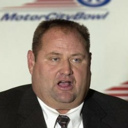
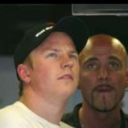
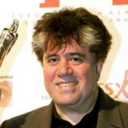
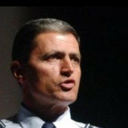

In [15]:
tfds.as_dataframe(ds.take(4), info)

In [31]:
label, data = tfds.as_numpy(tfds.load('LFW', split='train', batch_size=-1, as_supervised=True,))

In [32]:
type(data), data.shape, type(label), label.shape

(numpy.ndarray, (13233, 250, 250, 3), numpy.ndarray, (13233,))

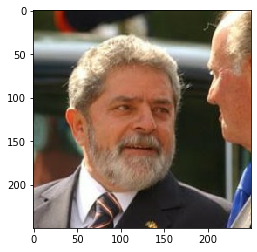

In [33]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")
plt.show()

Изменение размеров изображений.

In [ ]:
ImageDataGenerator

# Generative adversarial nets 101 (inspited by excellent Coursera course)


_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [37]:
CODE_SIZE = 10_000
IMG_SHAPE = data.shape[1:]

In [83]:
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE], name='noise'))
generator.add(L.Dense(100*100, activation='elu'))

generator.add(L.Reshape((100, 100, 1)))

generator.add(L.Conv2DTranspose(256, kernel_size=(10,10), activation='elu'))
generator.add(L.Conv2DTranspose(256, kernel_size=(8,8), activation='elu'))
generator.add(L.Conv2DTranspose(256, kernel_size=(8,8), activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))

generator.add(L.Conv2DTranspose(32, kernel_size=(3,3), activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=(3,3), activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=(3,3), activation='elu'))

generator.add(L.Conv2D(3, kernel_size=(3,3), activation=None))


In [84]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [100]:
generator.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [85]:
generator.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10000)             2570000   
_________________________________________________________________
reshape_24 (Reshape)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_transpose_132 (Conv2D (None, 109, 109, 256)     25856     
_________________________________________________________________
conv2d_transpose_133 (Conv2D (None, 116, 116, 256)     4194560   
_________________________________________________________________
conv2d_transpose_134 (Conv2D (None, 123, 123, 256)     4194560   
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 246, 246, 256)     0         
_________________________________________________________________
conv2d_transpose_135 (Conv2D (None, 248, 248, 32)    

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [98]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(3,3)))

discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.Conv2D(3, kernel_size=(3,3), activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(3,3)))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(1, activation='sigmoid'))


In [99]:
discriminator.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 248, 248, 3)       84        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 246, 246, 3)       84        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 244, 244, 3)       84        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 81, 81, 3)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 79, 79, 3)         84        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 77, 77, 3)         84        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 75, 75, 3)       

In [101]:
discriminator.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="images/gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [ ]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow, ncol, epoch, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.title(epoch)
    plt.show()

def sample_probas(bsize, epoch):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.title(epoch)
    plt.show()    

# Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [ ]:
generator.load_weights('gen.h5')
discriminator.load_weights('disc.h5')

In [105]:
inp_ = L.Input(shape=[CODE_SIZE])
out_ = discriminator(generator(inp_))
gan = Model(inputs=inp_, outputs=out_)

In [106]:
gan.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
from IPython import display

BATCH_SIZE = 100

for epoch in range(10):    
    # discriminator trains
    noise = np.random.random(size=(BATCH_SIZE,CODE_SIZE))
    generated_data = generator(noise)
    real_data = data[np.random.randint(data.shape[0], size=BATCH_SIZE)]
    
    target = np.ones(2*BATCH_SIZE)
    target[BATCH_SIZE:] = 1
  
    discriminator.trainable_weights = True
    discriminator.fit(gene)


    # generator trains
    discriminator.trainable_weights = False
    for i in range(5):
        s.run(disc_optimizer, feed_dict)
    
    s.run(gen_optimizer, feed_dict)
    
    if epoch %50==0:
        display.clear_output()
        sample_images(2, 3, epoch, True)
        sample_probas(1000, epoch)
        generator.save_weights('gen{}.h5'.format(epoch))    
        discriminator.save_weights('disc{}.h5'.format(epoch))

In [ ]:
from submit_honor import submit_honor
submit_honor((generator, discriminator), "yuchernyshov@usurt.ru", <YOUR_TOKEN>)

In [ ]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)